In [8]:
import time
import keras
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA, SparsePCA, TruncatedSVD
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score, ConfusionMatrixDisplay

from keras.models import Model, Sequential
from keras.layers import Input, Dense,Conv3D, MaxPooling3D, Flatten, Dropout
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.metrics import MeanIoU

# sess = tf.Session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

class Time():
    def __init__(self):
        self.begin = 0
        self.final = 0
    def reset(self):
        self.begin = time.time()
        self.final = time.time()        
    def start(self):
        self.begin = time.time()
    def end(self):
        self.final = time.time()
        print('\n>> Done!! Time taken: {:.4f} min'.format(float((self.final-self.begin))/60))

tm = Time()

Num GPUs Available:  0
Num CPUs Available:  1


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

import torch
torch.cuda.device_count()

/home/vm043/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


0

returns HSI image(np.array) with padding aroung boundary with zero of width equal to margin

In [2]:
def create_annotation(arr):
    anno = {}
    for i,ar in enumerate(arr):
        for j,ele in enumerate(ar):
            if arr[i,j] not in anno.keys():
                anno[ele]=[(i,j)]
            else:
                anno[ele].append((i,j))
    return anno.copy()

def data_for_training(df,test_size=0.1,val_size=0.2):
    data = {}
    data['train']=[]
    data['validation']=[]
    data['test']=[]
    for view in df.view.unique():
        temp = df[df.view==view].copy()
        train, val = train_test_split(temp, test_size=val_size, random_state=101)
        val, test = train_test_split(val, test_size=test_size, random_state=101)
        data['train'].extend(train.hdr.str[:-4].tolist())
        data['validation'].extend(val.hdr.str[:-4].tolist())
        data['test'].extend(test.hdr.str[:-4].tolist())
        del val,test,train,temp
    return data.copy()

def plot_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.figure(figsize = (15,9))# (x,y)

    plt.subplot(121)
    plt.plot(train_loss,label = 'Train Loss')
    plt.plot(val_loss,label = 'Validation Loss')
    plt.grid()
    plt.legend()
    plt.xticks(np.arange(1,epoch,step = 1))
    plt.xlabel('No. of Epochs-1')
    plt.ylabel('Value')
    plt.title('Loss')

    plt.subplot(122)
    plt.plot(train_acc,label = 'Train Accuracy')
    plt.plot(val_acc,label = 'Validation Accuracy')
    plt.grid()
    plt.xlabel('No. of Epochs-1')
    plt.legend()
    plt.xticks(np.arange(1,epoch,step = 1))
    plt.ylabel('Value')
    plt.title('Accuracy')

df = pd.read_csv('hsi_images.csv')
df['view'] = df.hdr.str.split('-').apply(lambda x:x[-1][:-4])
data = data_for_training(df,test_size=0.1,val_size=0.2)
#test_size is the ratio of test data that of validation data


data genarator reference: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 image_names,
                 batch_size=5,
                 kernel=5,
                 dim=(1280,1024),
                 n_channels=47,
                 dim_reduction_factor=2,
                 n_classes=2,
                 shuffle=True,
                 dim_reduction_method='PCA',
                 reduced_dim = 23):        
        self.image_names = image_names
        self.batch_size = batch_size
        self.dim = dim
        self.kernel = kernel
        self.patch = (kernel, kernel)
        self.n_channels = n_channels
        self.dim_reduction_factor = dim_reduction_factor
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.dim_reduction = dim_reduction_method
        self.reduced_dim = reduced_dim
        self.on_epoch_end()

    #Denotes the number of batches per epoch
    def __len__(self):
        return int(np.floor(len(self.image_names) / self.batch_size))

    #Updates indexes after each epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    #Generate one batch of data
    #Generate indexes of the batch
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        batch_images = [self.image_names[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(batch_images)
        return X, y

    #Dimensionality Reduction Methods
    def dim_reduction_method(self, method, HSI, NC = 26):
        RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
        if method == 'PCA': ## PCA
            pca = PCA(n_components = NC, whiten = True)
            RHSI = pca.fit_transform(RHSI)
            RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
        elif method == 'iPCA': ## Incremental PCA
            n_batches = 256
            inc_pca = IncrementalPCA(n_components = NC)
            for X_batch in np.array_split(RHSI, n_batches):
                inc_pca.partial_fit(X_batch)
            X_ipca = inc_pca.transform(RHSI)
            RHSI = np.reshape(X_ipca, (HSI.shape[0], HSI.shape[1], NC))
        elif method == 'KPCA': ## Kernel PCA
            kpca = KernelPCA(kernel = "rbf", n_components = NC, gamma = None, 
                              fit_inverse_transform = True, random_state = 2019, 
                              n_jobs=1)
            kpca.fit(RHSI)
            RHSI = kpca.transform(RHSI)
            RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
        elif method == 'SPCA': ## Sparse PCA
            sparsepca = SparsePCA(n_components = NC, alpha=0.0001, random_state=2019, n_jobs=-1)
            sparsepca.fit(RHSI)
            RHSI = sparsepca.transform(RHSI)
            RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
        elif method == 'SVD': ## Singular Value Decomposition
            SVD_ = TruncatedSVD(n_components = NC,algorithm = 'randomized', 
                                random_state = 2019, n_iter=5)
            SVD_.fit(RHSI)
            RHSI = SVD_.transform(RHSI)
            RHSI = np.reshape(RHSI, (HSI.shape[0], HSI.shape[1], NC))
        return RHSI.copy()

    def create_annotation(self,arr):
        anno = {}
        for i,ar in enumerate(arr):
            for j,ele in enumerate(ar):
                if arr[i,j] not in anno.keys():
                    anno[ele]=[(i,j)]
                else:
                    anno[ele].append((i,j))
        return anno.copy()
    
    #Generates data containing batch_size samples 
    #X : (n_samples, *patch, n_channels)       
    def data_generation(self, batch_images):
        dis = self.kernel//2
        X = np.zeros((self.dim[0]*self.dim[1],self.kernel,self.kernel,self.reduced_dim))
        Y,batch_length=np.array([]),0
        patch_index=0

        for i,image_name in enumerate(batch_images):
            image = np.load('./hsi/'+image_name+'.npy')
            reduced_image = self.dim_reduction_method(self.dim_reduction,image,NC=self.reduced_dim)
            npad = ((dis,dis),(dis,dis),(0, 0))
            padded_reduced_image = np.pad(reduced_image,npad,'reflect')
            
            annotation = np.load('./anno/'+image_name+'.npy').transpose()
            anno=self.create_annotation(annotation)
            zeros=len(anno[0])

            for (x,y) in anno[1]:
                X[patch_index,:,:,:]=padded_reduced_image[x:x+2*dis+1,y:y+2*dis+1,:].copy()
                Y = np.append(Y,[1])
                patch_index+=1
                
                rand = random.randint(0,zeros-1)
                (xo,yo)=anno[0][rand]
                X[patch_index,:,:,:]=padded_reduced_image[xo:xo+2*dis+1,yo:yo+2*dis+1,:].copy()
                Y = np.append(Y,[0])
                patch_index+=1
                    
        X = X[0:patch_index,:,:,:].copy()
        return X, keras.utils.to_categorical(Y, num_classes=self.n_classes)

In [9]:
tm.start()
train_generator = DataGenerator(data['train'])
train_generator.data_generation(data['train'][:2])
tm.end()


>> Done!! Time taken: 0.2733 min


In [ ]:
KERNEL = 5
REDUCED_DIM = 23
EPOCHS = 10
WORKERS = 6


In [18]:
inputs = Input((KERNEL,KERNEL,REDUCED_DIM,1))
conv1 = Conv3D(filters=8, kernel_size=(3, 3, 3),activation='relu',padding='same')(inputs)
conv2 = Conv3D(filters=16, kernel_size=(3, 3, 3),activation='relu',padding='same')(conv1)

drop = Dropout(0.5)(conv2)
conv3 = Conv3D(filters=32, kernel_size=(3, 3, 3),activation='relu',padding='same')(drop)
conv4 = Conv3D(filters=64, kernel_size=(3, 3, 3),activation='relu',padding='same')(conv3)
flat = Flatten()(conv4)

dense1 = Dense(units=256, activation='relu')(flat)
dense2 = Dense(units=128, activation='relu')(dense1)
outputs = Dense(units=2, activation='softmax')(dense2)

model = Model(inputs, outputs)

adam = Adam(learning_rate = 0.001, decay = 1e-06)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5, 5, 23, 1)]     0         
                                                                 
 conv3d_32 (Conv3D)          (None, 5, 5, 23, 8)       224       
                                                                 
 conv3d_33 (Conv3D)          (None, 5, 5, 23, 16)      3472      
                                                                 
 dropout_5 (Dropout)         (None, 5, 5, 23, 16)      0         
                                                                 
 conv3d_34 (Conv3D)          (None, 5, 5, 23, 32)      13856     
                                                                 
 conv3d_35 (Conv3D)          (None, 5, 5, 23, 64)      55360     
                                                                 
 flatten_4 (Flatten)         (None, 36800)             0   

In [ ]:
train_generator = DataGenerator(data['train'])
val_generator = DataGenerator(data['validation'])

history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs=EPOCHS
                              use_multiprocessing=True,
                              workers=WORKERS)

plot_history(history)

/tmp/ipykernel_1544231/816785037.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,
2023-01-24 23:44:02.062322: I tensorflow/core/common_runtime/executor.cc:1195] [/device:CPU:0] Executor start aborting: INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/vm043/anaconda3/lib/python3.9/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Process Keras_worker_ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/vm043/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/vm043/ana

  File "/tmp/ipykernel_1544231/699433900.py", line 43, in __getitem__
    X, y = self.__data_generation(batch_images)
  File "/tmp/ipykernel_1544231/699433900.py", line 100, in __data_generation
    reduced_image = self.dim_reduction_method(self.dim_reduction,image,NC=self.reduced_dim)
  File "/tmp/ipykernel_1544231/699433900.py", line 51, in dim_reduction_method
    RHSI = pca.fit_transform(RHSI)
  File "/home/vm043/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py", line 407, in fit_transform
    U, S, Vt = self._fit(X)
  File "/home/vm043/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_pca.py", line 459, in _fit
    return self._fit_truncated(X, n_components, self._fit_svd_solver)
  File "/home/vm043/anaconda3/lib/python3.9/site-packages/sklearn/utils/extmath.py", line 245, in randomized_range_finder
    Q, _ = linalg.qr(safe_sparse_dot(A, Q), mode="economic")
  File "/home/vm043/anaconda3/lib/python3.9/site-packages/scipy/linalg/_decomp_qr.py", line 1

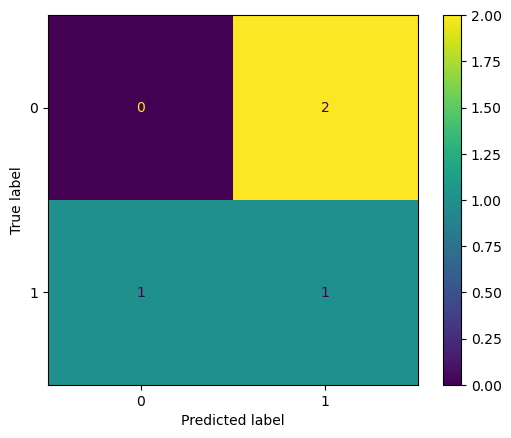

In [6]:
tn,fp,fn,tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
cm = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()